<a href="https://colab.research.google.com/github/hardiksahi/MachineLearning/blob/main/3_OLS_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ridge regression:
- https://www.youtube.com/watch?v=Q81RR3yKn30
- https://stats.stackexchange.com/questions/104779/why-does-ridge-regression-work-well-in-the-presence-of-multicollinearity
- https://stats.stackexchange.com/questions/70899/what-correlation-makes-a-matrix-singular-and-what-are-implications-of-singularit/70910#70910

**Singular/ Nearly singular matrix (Ill-conditioned)**

https://stats.stackexchange.com/questions/70899/what-correlation-makes-a-matrix-singular-and-what-are-implications-of-singularit/70910#70910

Consider a matrix with collinear/ nearly collinear columns(linear interdependence) X.
Then, Matrix XTX is singular/ nealy singular

1. The dependency observed in such matrix between its columns is actually that same dependency as the dependency between the variables in the data observed after the variables have been centered (their means brought to 0) or standardized (if we mean correlation rather than covariance matrix).

**Singularity as geometric collinearity**

In geometrical viewpoint, singularity is (multi)collinearity (or "complanarity"): variables displayed as vectors (arrows) in space lie in the space of dimentionality lesser than the number of variables - in a reduced space

**Collinearity in regression: a geometric explanation and implications**
1. No collinear columns => Normal regression/ OLS possible since XTX is invertible/ non singular => Unique plae through the data points exists.

2. Columns completely collinear => Some columns redundant => Drop them and learn unique plane in reduced dimension OR Use Ridge regression etc

3. Nearly collinear columns => Very small angle between variables represented as vectors => Even slight change in data will change vector => Huge change in plane fitted through data points => UNRELIABLE COEFFICIENT ESTIMATES AS CAN BE SEEN FROM HUGE STANDARD DEVIATIONS





**Comparison of OLS and Ridge in terms of variance and bias (overfitting)**

Ordinary Least Squares:


1.   OLS generally overfits the training data as its only purpose is to minize SSR.
2.   This leads to parameters getting large values => 1 unit change in input leads to large average change in output
3. This means that output is very sensitive to small changes in input. This implies very high variance.

Ridge regression:


1.   Ridge regression helps resolve this by introducing some bias (by forcing parameters to take smaller values). This ensures that 1 unit change in input leads to small chage in output on average.
2.   Prevent overfitting on training data by introducing some bias
3. Make model less sensitive to changes in input variables by shrinking parameter values (reduce variance)


**Comparison of OLS and Ridge in terms of handling high dimensional data**

OLS:
1. Needs #rows >= # features to be able to find unique solution.
2. With # rows < # features => XTX will be singular/ ill conditioned matrix (singularity is (multi)collinearity (or "complanarity")) => Inverse of XTX does not exist => Unable to solve

Ridge regression:

1. Can work with high dimensional data where # rows/ examples < # features
2. Very useful in a lot of cases where we have limited data/ data collection is expensive

**Comparison of OLS and Ridge regression in terms of handling collinear/ nearly collinear independent variables (multicollinearity)**

https://stats.stackexchange.com/questions/104779/why-does-ridge-regression-work-well-in-the-presence-of-multicollinearity

OLS:



1.   Fails to work since XTX is singular/ non invertible

Ridge:

1. Imposes contraint that coefficients should be small.
2. This means that for 2 correlated variables X1, X2 with small coefficients (due to penalty), change in input does not have a huge impact on output.



In [1]:
import pandas as pd
import numpy as np

In [2]:
import random

In [3]:
from numpy.linalg import cond, inv

In [288]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [6]:
from sklearn.preprocessing import StandardScaler

In [336]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold

In [322]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

In [ ]:
## 1. Covariance and correlation of matrix (non collinear and collinear columns)
## 2. OLS (Impact of standardization)

## Step 1: Calculate covariance between 2 RV (2 vectors x and y)

In [7]:
x_vector = np.random.rand(20,)
y_vector = np.random.rand(20,)

In [8]:
cov_x_y = np.dot(x_vector-np.mean(x_vector), y_vector-np.mean(y_vector))/(x_vector.shape[0]-1)
print(f"cov_x_y: {cov_x_y}")
print(f"Is calculated covariance same as numpy covariance: {np.allclose(np.cov(x_vector, y_vector)[0][1], cov_x_y)}")

cov_x_y: -0.007758992149440621
Is calculated covariance same as numpy covariance: True


In [ ]:
## Calculate covariance as Expected values : Cov(X, Y) = E(XY)- E(X)E(Y)
## For this calculation we need Joint Probabiulity distribution of X, Y
## https://online.stat.psu.edu/stat414/lesson/18/18.1

## Step 2: Calculate Covariance Matrix

In [9]:
def calculate_covariance_matrix(X):
  row_count = X.shape[0]
  column_mean_vector = np.mean(X, axis=0)
  centered_X = X-column_mean_vector
  cov_matrix = np.dot(centered_X.transpose(), centered_X)
  cov_matrix = cov_matrix/(row_count-1)
  return cov_matrix

In [10]:
def calculate_vif(df):
  vif_df = pd.DataFrame()
  vif_df["feature"] = df.columns
  vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
  return vif_df

In [11]:
def calculate_correlation_matrix(X):
  covariance_matrix = calculate_covariance_matrix(X)
  variance_array = covariance_matrix.diagonal()
  std_array = np.sqrt(variance_array)

  correlation_matrix = covariance_matrix/std_array.reshape(1,-1)
  correlation_matrix = correlation_matrix/std_array.reshape(-1,1)
  return correlation_matrix

In [12]:
def check_invertibility(square_matrix):
  condition_number = cond(square_matrix)
  inverse = inv(square_matrix)
  return condition_number, np.allclose(square_matrix @ inverse, np.eye(square_matrix.shape[0])), np.allclose(np.eye(square_matrix.shape[0]), square_matrix @ inverse)

## Case1: # rows > # columns (Covariance matrix is invertible since # rows > # columns)


In [13]:
case1_n_rows = 4
case1_n_columns = 3
case1_X = pd.DataFrame(np.random.rand(case1_n_rows, case1_n_columns))
case1_X.columns = [f"feature_{col}" for col in case1_X.columns]
print(f"Shape of case1_X: {case1_X.shape}")

Shape of case1_X: (4, 3)


In [14]:
## Clear that the features are not collinear
calculate_vif(case1_X).sort_values(by=["VIF"], ascending=False).head()

,feature,VIF
1,feature_1,23.072377
0,feature_0,14.265499
2,feature_2,5.439282


In [15]:
case1_cov_matrix = calculate_covariance_matrix(case1_X)
print(f"case1_cov_matrix:\n {case1_cov_matrix}")
print(f"Is calculated covariance same as numpy covariance: {np.allclose(case1_cov_matrix, np.cov(case1_X, rowvar=False, bias=False))}")

case1_cov_matrix:
 [[ 0.13739123  0.08447621 -0.1334639 ]
 [ 0.08447621  0.10506623 -0.03883213]
 [-0.1334639  -0.03883213  0.18865037]]
Is calculated covariance same as numpy covariance: True


In [16]:
case1_corr_matrix = calculate_correlation_matrix(case1_X)
print(f"case1_corr_matrix:\n {case1_corr_matrix}")
print(f"Is calculated correlation same as numpy correlation: {np.allclose(case1_corr_matrix, np.corrcoef(case1_X, rowvar=False))}")

case1_corr_matrix:
 [[ 1.          0.70311012 -0.82900183]
 [ 0.70311012  1.         -0.27582321]
 [-0.82900183 -0.27582321  1.        ]]
Is calculated correlation same as numpy correlation: True


In [17]:
scaled_case1_X = StandardScaler(with_mean=True, with_std=True).fit_transform(case1_X)
case1_corr_matrix_using_scaler = np.dot(scaled_case1_X.transpose(), scaled_case1_X)/(scaled_case1_X.shape[0])
np.allclose(case1_corr_matrix_using_scaler, np.corrcoef(case1_X, rowvar=False))

True

In [18]:
## Check if case1_cov_matrix is invertible => YES => WELL CONDITIONED MATRIX
# case1_cov_matrix_inv = inv(case1_cov_matrix)
# print(np.allclose(case1_cov_matrix @ case1_cov_matrix_inv, np.eye(case1_cov_matrix.shape[0])))
# print(np.allclose(np.eye(case1_cov_matrix.shape[0]), case1_cov_matrix @ case1_cov_matrix_inv))
# print(f"Condition number of case1_cov_matrix: {cond(case1_cov_matrix)}")
check_invertibility(case1_corr_matrix)

(56.84323156124705, True, True)

In [19]:
check_invertibility(case1_corr_matrix)

(56.84323156124705, True, True)

In [20]:
check_invertibility(case1_corr_matrix_using_scaler)

(56.84323156124709, True, True)

In [21]:
case1_XTX = np.dot(case1_X.transpose(), case1_X)
check_invertibility(case1_XTX)

(98.61438382700535, True, True)

## Case2: # rows < # columns (Covariance matrix is NOT invertible since # rows < # columns) (High dimensional data suffering from curse of dimensionality)


In [22]:
case2_n_rows = 200
case2_n_columns = 201
case2_X = pd.DataFrame(np.random.rand(case2_n_rows, case2_n_columns))
case2_X.columns = [f"feature_{col}" for col in case2_X.columns]
print(f"Shape of case2_X: {case2_X.shape}")

Shape of case2_X: (200, 201)


In [23]:
## Clear that there is high degree of collinearity in this case when # features > # rows/ observations
calculate_vif(case2_X).sort_values(by=["VIF"], ascending=False).head()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,feature,VIF
0,feature_0,inf
138,feature_138,inf
128,feature_128,inf
129,feature_129,inf
130,feature_130,inf


In [24]:
case2_cov_matrix = calculate_covariance_matrix(case2_X)
print(f"case2_cov_matrix: {case2_cov_matrix}")
print(f"Is calculated covariance same as numpy covariance: {np.allclose(case2_cov_matrix, np.cov(case2_X, rowvar=False, bias=False))}")

case2_cov_matrix: [[ 8.54892205e-02 -8.00968889e-04 -6.12717697e-03 ...  7.78679382e-04
  -8.01350247e-03 -2.66485593e-05]
 [-8.00968889e-04  8.19348415e-02  2.35536518e-03 ...  1.06153780e-03
   5.19425846e-03  7.28368847e-03]
 [-6.12717697e-03  2.35536518e-03  7.79697160e-02 ...  3.19331769e-03
   2.83019888e-03  4.53842456e-03]
 ...
 [ 7.78679382e-04  1.06153780e-03  3.19331769e-03 ...  9.51212946e-02
   7.86406349e-03  1.65238282e-03]
 [-8.01350247e-03  5.19425846e-03  2.83019888e-03 ...  7.86406349e-03
   9.13131249e-02 -2.05019619e-03]
 [-2.66485593e-05  7.28368847e-03  4.53842456e-03 ...  1.65238282e-03
  -2.05019619e-03  8.02643264e-02]]
Is calculated covariance same as numpy covariance: True


In [25]:
case2_corr_matrix = calculate_correlation_matrix(case2_X)
print(f"case2_corr_matrix:\n {case2_corr_matrix}")
print(f"Is calculated correlation same as numpy correlation: {np.allclose(case2_corr_matrix, np.corrcoef(case2_X, rowvar=False))}")

case2_corr_matrix:
 [[ 1.00000000e+00 -9.57030239e-03 -7.50484574e-02 ...  8.63503537e-03
  -9.06984978e-02 -3.21704231e-04]
 [-9.57030239e-03  1.00000000e+00  2.94686992e-02 ...  1.20243685e-02
   6.00513318e-02  8.98164263e-02]
 [-7.50484574e-02  2.94686992e-02  1.00000000e+00 ...  3.70800469e-02
   3.35418781e-02  5.73694732e-02]
 ...
 [ 8.63503537e-03  1.20243685e-02  3.70800469e-02 ...  1.00000000e+00
   8.43803908e-02  1.89108266e-02]
 [-9.06984978e-02  6.00513318e-02  3.35418781e-02 ...  8.43803908e-02
   1.00000000e+00 -2.39479055e-02]
 [-3.21704231e-04  8.98164263e-02  5.73694732e-02 ...  1.89108266e-02
  -2.39479055e-02  1.00000000e+00]]
Is calculated correlation same as numpy correlation: True


In [26]:
scaled_case2_X = StandardScaler(with_mean=True, with_std=True).fit_transform(case2_X)
case2_corr_matrix_using_scaler = np.dot(scaled_case2_X.transpose(), scaled_case2_X)/(scaled_case2_X.shape[0])
np.allclose(case2_corr_matrix_using_scaler, np.corrcoef(case2_X, rowvar=False))

True

In [27]:
check_invertibility(case2_cov_matrix)

(5.080114051211909e+16, False, False)

In [28]:
check_invertibility(case2_corr_matrix)

(8.887956518261245e+16, False, False)

In [29]:
check_invertibility(case2_corr_matrix_using_scaler)

(4.897857352665361e+16, False, False)

In [30]:
case2_XTX = np.dot(case2_X.transpose(), case2_X)
check_invertibility(case2_XTX)

(1.757725749112051e+17, False, False)

This shows that standardizing variables (as in covariance/ correlation matrix) does not impact the singularity/ non singularity of the matrix.

- This is similar in observation to fitting OLS i.e. if the data has multicollinearity that is NOT STRUCTURAL, it cannot be gotten rid of by standardization (https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)

TL:DR;
- Given a design matrix X, XTX is well conditioned/ invertible/ non-singular if #rows > #columns. Equivalently, X has non collinear columns. Hence no issue of multicollinearity as can be checked using VIF scores

- Given a design matrix X, XTX is ill conditioned/ non-invertible/ singular if #rows < #columns. Equivalently, X has multicollinearity (CURSE OF DIMENSIONALITY)

## Case3: # rows > # columns BUT columns are collinear => 1 column is linear combination of others

In [32]:
case3_n_rows = 100
case3_n_columns = 3

case3_X = pd.DataFrame(np.random.rand(case3_n_rows, case3_n_columns-1))
case3_X[case3_n_columns-1] = np.sum(case3_X, axis=1)
case3_X.columns = [f"feature_{col}" for col in case3_X.columns]
print(f"Shape of case3_X: {case3_X.shape}")

Shape of case3_X: (100, 3)


In [33]:
## Clear that the features are collinear
calculate_vif(case3_X).sort_values(by=["VIF"], ascending=False).head()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,feature,VIF
0,feature_0,inf
1,feature_1,inf
2,feature_2,inf


In [34]:
case3_cov_matrix = calculate_covariance_matrix(case3_X)
print(f"case3_cov_matrix: {case3_cov_matrix}")
print(f"Is calculated covariance same as numpy covariance: {np.allclose(case3_cov_matrix, np.cov(case3_X, rowvar=False, bias=False))}")

case3_cov_matrix: [[0.08985599 0.00770104 0.09755703]
 [0.00770104 0.07408521 0.08178625]
 [0.09755703 0.08178625 0.17934329]]
Is calculated covariance same as numpy covariance: True


In [35]:
case3_corr_matrix = calculate_correlation_matrix(case3_X)
print(f"case3_corr_matrix:\n {case3_corr_matrix}")
print(f"Is calculated correlation same as numpy correlation: {np.allclose(case3_corr_matrix, np.corrcoef(case3_X, rowvar=False))}")

case3_corr_matrix:
 [[1.         0.09438656 0.76849757]
 [0.09438656 1.         0.709532  ]
 [0.76849757 0.709532   1.        ]]
Is calculated correlation same as numpy correlation: True


In [36]:
scaled_case3_X = StandardScaler(with_mean=True, with_std=True).fit_transform(case3_X)
case3_corr_matrix_using_scaler = np.dot(scaled_case3_X.transpose(), scaled_case3_X)/(scaled_case3_X.shape[0])
np.allclose(case3_corr_matrix_using_scaler, np.corrcoef(case3_X, rowvar=False))

True

In [37]:
check_invertibility(case3_cov_matrix)

(5892431816569248.0, False, False)

In [38]:
check_invertibility(case3_corr_matrix)

(7451681118708913.0, False, False)

In [39]:
check_invertibility(case3_corr_matrix_using_scaler)

(4012443679304795.5, False, False)

In [40]:
case3_XTX = np.dot(case3_X.transpose(), case3_X)
check_invertibility(case3_XTX)

(5928576176928156.0, False, False)

- Clearly, if columns are collinear => inverse does not exist/ XTX is singular/ non-invertible

## Case4: # rows > # columns BUT a column is standardized version of another [This case should not occur in real datasets.]

In [41]:
case4_n_rows = 100
case4_n_columns = 5

case4_X = pd.DataFrame(np.random.rand(case4_n_rows, case4_n_columns-1))
choose_random_feature_index = random.choice(range(case4_n_columns-1))
case4_X[case4_n_columns-1] = (case4_X[choose_random_feature_index]-np.mean(case4_X[choose_random_feature_index]))#/np.var(case4_X[choose_random_feature_index])
case4_X.columns = [f"feature_{col}" for col in case4_X.columns]
print(f"Shape of case4_X: {case4_X.shape}")

Shape of case4_X: (100, 5)


In [42]:
## COlumns are not collinear
calculate_vif(case4_X).sort_values(by=["VIF"], ascending=False).head()

,feature,VIF
1,feature_1,13.161066
4,feature_4,3.405338
2,feature_2,1.064522
3,feature_3,1.049254
0,feature_0,1.036445


In [43]:
case4_cov_matrix = calculate_covariance_matrix(case4_X)
print(f"case4_cov_matrix: {case4_cov_matrix}")
print(f"Is calculated covariance same as numpy covariance: {np.allclose(case4_cov_matrix, np.cov(case4_X, rowvar=False, bias=False))}")

case4_cov_matrix: [[ 0.07718275  0.00655642  0.00491709 -0.01205426  0.00655642]
 [ 0.00655642  0.08367158  0.02078118  0.01023961  0.08367158]
 [ 0.00491709  0.02078118  0.09749076  0.00897982  0.02078118]
 [-0.01205426  0.01023961  0.00897982  0.08390721  0.01023961]
 [ 0.00655642  0.08367158  0.02078118  0.01023961  0.08367158]]
Is calculated covariance same as numpy covariance: True


In [44]:
case4_corr_matrix = calculate_correlation_matrix(case4_X)
print(f"case4_corr_matrix:\n {case4_corr_matrix}")
print(f"Is calculated correlation same as numpy correlation: {np.allclose(case4_corr_matrix, np.corrcoef(case4_X, rowvar=False))}")

case4_corr_matrix:
 [[ 1.          0.0815864   0.05668481 -0.14978933  0.0815864 ]
 [ 0.0815864   1.          0.23009091  0.12220669  1.        ]
 [ 0.05668481  0.23009091  1.          0.0992856   0.23009091]
 [-0.14978933  0.12220669  0.0992856   1.          0.12220669]
 [ 0.0815864   1.          0.23009091  0.12220669  1.        ]]
Is calculated correlation same as numpy correlation: True


In [45]:
scaled_case4_X = StandardScaler(with_mean=True, with_std=True).fit_transform(case4_X)
case4_corr_matrix_using_scaler = np.dot(scaled_case4_X.transpose(), scaled_case4_X)/(scaled_case4_X.shape[0])
np.allclose(case4_corr_matrix_using_scaler, np.corrcoef(case4_X, rowvar=False))

True

In [46]:
check_invertibility(case4_cov_matrix)

LinAlgError: Singular matrix

In [47]:
check_invertibility(case4_corr_matrix)

LinAlgError: Singular matrix

In [48]:
check_invertibility(case4_corr_matrix_using_scaler)

LinAlgError: Singular matrix

In [49]:
case4_XTX = np.dot(case4_X.transpose(), case4_X)
check_invertibility(case4_XTX)

(90.05579799653138, True, True)

- Case4: Covariance matrix is singular/ has very high condition number

Conclusion:
1. Case1: # rows > # features and columns are not collinear => COV/ CORR: Invertible, XTX Invertible
2. Case3: # rows > # features AND columns are collinear/ linearly dependent => COV/ CORR: Non Invertible, XTX Non invertible
3. Case 4: # rows > # features AND a column is merely centered OR standardized version of another column => COV/ CORR: Non Invertible, XTX Invertible
4. Case2: # rows < # features => COV/ CORR: Non Invertible, XTX Non invertible



## Can adding some noise to XTX along diagnal make singular matrix to non singular??

In [50]:
lambda_val = 0.01

## Case 1: Adding some noise along diagnal makes matrix invertible

In [51]:
check_invertibility(case1_cov_matrix + lambda_val*np.eye(case1_cov_matrix.shape[0]))

(21.919847227861844, True, True)

In [52]:
check_invertibility(case1_corr_matrix + lambda_val*np.eye(case1_corr_matrix.shape[0]))

(45.50945476773307, True, True)

In [53]:
## case1_corr_matrix_using_scaler
check_invertibility(case1_corr_matrix_using_scaler + lambda_val*np.eye(case1_corr_matrix_using_scaler.shape[0]))

(45.50945476773315, True, True)

In [54]:
check_invertibility(case1_XTX + lambda_val*np.eye(case1_XTX.shape[0]))

(76.736051868382, True, True)

## Case 2: Adding some noise along diagnal makes matrix invertible

In [55]:
check_invertibility(case2_cov_matrix + lambda_val*np.eye(case2_cov_matrix.shape[0]))

(33.928320115151664, True, True)

In [56]:
check_invertibility(case2_corr_matrix + lambda_val*np.eye(case2_corr_matrix.shape[0]))

(392.750416812755, True, True)

In [57]:
check_invertibility(case2_corr_matrix_using_scaler + lambda_val*np.eye(case2_corr_matrix_using_scaler.shape[0]))

(392.75041681275087, True, True)

In [58]:
check_invertibility(case2_XTX + lambda_val*np.eye(case2_XTX.shape[0]))

(1006514.138416777, True, True)

## Case 3: Adding some noise along diagnal makes matrix invertible

In [59]:
check_invertibility(case3_cov_matrix + lambda_val*np.eye(case3_cov_matrix.shape[0]))

(27.99681188686429, True, True)

In [60]:
check_invertibility(case3_corr_matrix + lambda_val*np.eye(case3_corr_matrix.shape[0]))

(210.40816442207904, True, True)

In [61]:
## case3_corr_matrix_using_scaler
check_invertibility(case3_corr_matrix_using_scaler + lambda_val*np.eye(case3_corr_matrix_using_scaler.shape[0]))

(210.40816442208134, True, True)

In [62]:
check_invertibility(case3_XTX + lambda_val*np.eye(case3_XTX.shape[0]))

(19686.952347091, True, True)

## Case 4: Adding some noise along diagnal makes matrix invertible

In [63]:
check_invertibility(case4_cov_matrix + lambda_val*np.eye(case4_cov_matrix.shape[0]))

(19.159176287602026, True, True)

In [64]:
check_invertibility(case4_corr_matrix + lambda_val*np.eye(case4_corr_matrix.shape[0]))

(214.88108655091278, True, True)

In [65]:
## case4_corr_matrix_using_scaler
check_invertibility(case4_corr_matrix_using_scaler + lambda_val*np.eye(case4_corr_matrix_using_scaler.shape[0]))

(214.88108655091577, True, True)

In [66]:
check_invertibility(case4_XTX + lambda_val*np.eye(case4_XTX.shape[0]))

(89.31476956371614, True, True)

- This shows that adding noise long diagnol makes previously singular matrices not singular.

# Linear Regression (OLS)
- https://machinelearningcompass.com/machine_learning_models/linear_regression/

In [67]:
from sklearn.datasets import make_regression
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
X, y = make_regression(n_samples=20, n_features=1, noise=20, bias=100, random_state=42)
gt_df = pd.DataFrame({"feature_1": X.reshape(-1,), "y": y, "type": "gt"})
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (20, 1)
Shape of y: (20,)


<Axes: xlabel='feature_1', ylabel='y'>

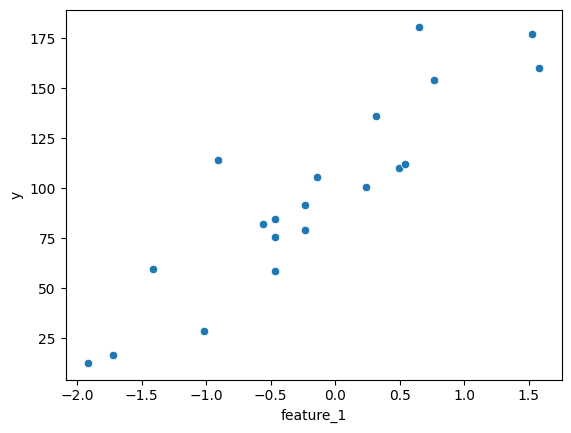

In [69]:
sns.scatterplot(data=gt_df, x="feature_1", y="y")

In [70]:
beta_ols = np.dot(inv(np.dot (X.transpose(), X)), np.dot(X.transpose(),y.reshape(y.shape[0], 1)))

In [71]:
beta_ols

array([[25.87673055]])

In [72]:
prediction_ols = np.dot(X, beta_ols)
print(f"Shape of prediction_ols: {prediction_ols.shape}")

Shape of prediction_ols: (20, 1)


In [73]:
ols_prediction_df = pd.DataFrame({"feature_1": X.reshape(-1,), "y": prediction_ols.reshape(-1,), "type": "ols_prediction"})

In [74]:
concat_ols_prediction_df = pd.concat([gt_df, ols_prediction_df], axis=0)

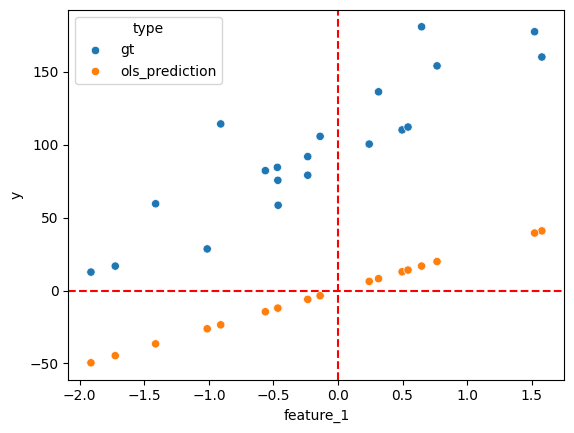

In [75]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=concat_ols_prediction_df, x="feature_1", y="y", hue="type", ax=axes)
axes.axhline(0, color='r', linestyle="--")
axes.axvline(0, color='r', linestyle="--")

- If there is no bias term, the model is forced to pass through origin

In [76]:
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.041
Date:                Sun, 04 Aug 2024   Prob (F-statistic):                       0.320
Time:                        03:00:53   Log-Likelihood:                         -121.49
No. Observations:                  20   AIC:                                      245.0
Df Residuals:                      19   BIC:                                      246.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            25.8767     25.364      1.020      0.320     -27.210      78.964
==============================================================================
Omnibus:                        0.493   Durbin-Watson:                   0.129
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.490
Skew:                           0.315   Prob(JB):                        0.783
Kurtosis:                       2.564   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Way 1: Do not centre variables BUT add bias
## Why add bias: https://stackoverflow.com/questions/60726185/in-what-circumstances-might-using-biases-in-a-neural-network-not-be-beneficial#:~:text=It%20is%20clearer%20to%20see,process%20is%20Y%3D3000).

In [77]:
## Since the data is not centered, add bias term to let model learn its value
X_with_bias = np.hstack((X, np.ones((X.shape[0], 1))))
print(f"Shape of X_with_bias: {X_with_bias.shape}")

Shape of X_with_bias: (20, 2)


In [78]:
beta_ols_with_bias = np.dot(inv(np.dot(X_with_bias.transpose(), X_with_bias)), np.dot(X_with_bias.transpose(), y))
print(f"Shape of beta_ols_with_bias: {beta_ols_with_bias.shape}")

Shape of beta_ols_with_bias: (2,)


In [79]:
beta_ols_with_bias

array([ 45.71245144, 104.78571437])

In [80]:
prediction_ols_with_bias = np.dot(X_with_bias, beta_ols_with_bias)
print(f"Shape of prediction_ols_with_bias: {prediction_ols_with_bias.shape}")

Shape of prediction_ols_with_bias: (20,)


In [81]:
ols_prediction_with_bias_df = pd.DataFrame({"feature_1": X.reshape(-1,), "y": prediction_ols_with_bias.reshape(-1,), "type": "ols_prediction_with_bias"})

In [82]:
concat_ols_prediction_with_bias_df = pd.concat([gt_df, ols_prediction_with_bias_df], axis=0)

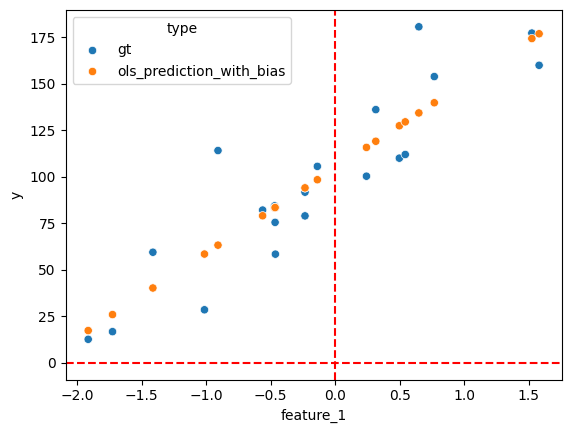

In [167]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=concat_ols_prediction_with_bias_df, x="feature_1", y="y", hue="type", ax=axes)
axes.axhline(0, color='r', linestyle="--")
axes.axvline(0, color='r', linestyle="--")

- It is clear that that bias helps move the line up or down and not force it through origin. This gives better fit in this case

In [84]:
## AUtomatically adds constant column for bias
model1 = ols('y ~ feature_1', data=gt_df).fit()

In [85]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     75.38
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           7.50e-08
Time:                        03:01:24   Log-Likelihood:                -89.176
No. Observations:                  20   AIC:                             182.4
Df Residuals:                      18   BIC:                             184.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.7857      5.009     20.921      0.000      94.263     115.308
feature_1     45.7125      5.265      8.682      0.000      34.651      56.774
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                3.386
Skew:                           0.982   Prob(JB):                        0.184
Kurtosis:                       3.450   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Coefficients from beta_ols_with_bias and statsmodels library match

In [86]:
sm.OLS(y,sm.add_constant(X), hasconst=True).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     75.38
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           7.50e-08
Time:                        03:01:29   Log-Likelihood:                -89.176
No. Observations:                  20   AIC:                             182.4
Df Residuals:                      18   BIC:                             184.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.7857      5.009     20.921      0.000      94.263     115.308
x1            45.7125      5.265      8.682      0.000      34.651      56.774
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                3.386
Skew:                           0.982   Prob(JB):                        0.184
Kurtosis:                       3.450   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Way 2: Centre input and output variables WITHOUT ADDING BIAS
## This is known as standardized regression. The interpretation of coefficients changes. Refer to https://www.statlect.com/fundamentals-of-statistics/linear-regression-with-standardized-variables for more details

- No need to add constant when doing standardized regression

In [87]:
X_standardize = StandardScaler().fit_transform(X)
y_standardize = StandardScaler().fit_transform(y.reshape(y.shape[0], 1))
standardize_gt_df = pd.DataFrame({"feature_1": X_standardize.reshape(-1,), "y": y_standardize.reshape(-1,), "type": "gt"})
print(f"Shape of X_standardize: {X_standardize.shape}")

Shape of X_standardize: (20, 1)


<Axes: xlabel='feature_1', ylabel='y'>

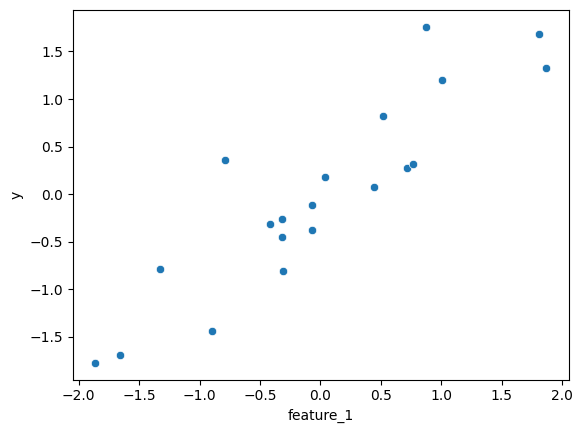

In [88]:
sns.scatterplot(data=standardize_gt_df, x="feature_1", y="y")

In [89]:
standardize_beta_ols = np.dot(inv(np.dot (X_standardize.transpose(), X_standardize)), np.dot(X_standardize.transpose(),y_standardize.reshape(y_standardize.shape[0], 1)))

In [90]:
standardize_beta_ols

array([[0.89846139]])

In [91]:
prediction_ols_standardize = np.dot(X_standardize, standardize_beta_ols)
print(f"Shape of prediction_ols_standardize: {prediction_ols_standardize.shape}")

Shape of prediction_ols_standardize: (20, 1)


In [92]:
ols_prediction_standardize_df = pd.DataFrame({"feature_1": X_standardize.reshape(-1,), "y": prediction_ols_standardize.reshape(-1,), "type": "ols_prediction_standardize"})

In [93]:
concat_ols_prediction_standardize_df = pd.concat([standardize_gt_df, ols_prediction_standardize_df], axis=0)

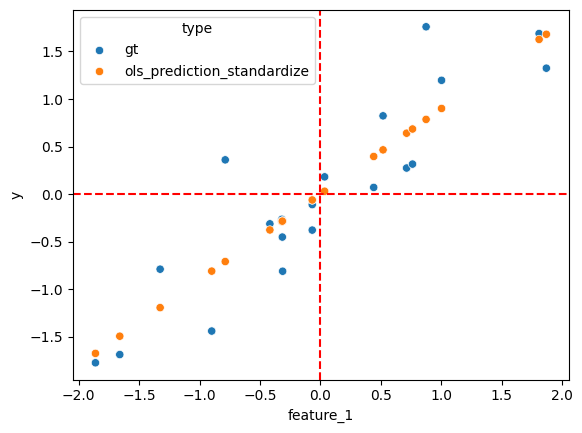

In [94]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=concat_ols_prediction_standardize_df, x="feature_1", y="y", hue="type", ax=axes)
axes.axhline(0, color='r', linestyle="--")
axes.axvline(0, color='r', linestyle="--")

In [143]:
## Validate above using statsmodels
sm.OLS(y_standardize,X_standardize, hasconst=False).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.807
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              79.56
Date:                Sun, 04 Aug 2024   Prob (F-statistic):                    3.21e-08
Time:                        03:27:11   Log-Likelihood:                         -11.916
No. Observations:                  20   AIC:                                      25.83
Df Residuals:                      19   BIC:                                      26.83
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8985      0.101      8.920      0.000       0.688       1.109
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                3.386
Skew:                           0.982   Prob(JB):                        0.184
Kurtosis:                       3.450   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
standardize_stats_model = sm.OLS(y_standardize,sm.add_constant(X_standardize), hasconst=True)#.fit().summary()
standardize_stats_model_results = standardize_stats_model.fit()

In [145]:
standardize_stats_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     75.38
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           7.50e-08
Time:                        03:27:24   Log-Likelihood:                -11.916
No. Observations:                  20   AIC:                             27.83
Df Residuals:                      18   BIC:                             29.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.327e-17      0.103   8.05e-16      1.000      -0.217       0.217
x1             0.8985      0.103      8.682      0.000       0.681       1.116
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                3.386
Skew:                           0.982   Prob(JB):                        0.184
Kurtosis:                       3.450   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
standardize_stats_model_prediction = standardize_stats_model.predict(params=standardize_stats_model_results.params, exog=sm.add_constant(X_standardize))
standardize_stats_model_df = pd.DataFrame({"feature_1": X_standardize.reshape(-1,), "y": standardize_stats_model_prediction.reshape(-1,), "type": "ols_prediction_standardize_stats_model"})

In [148]:
concat_standardize_stats_model_df = pd.concat([standardize_gt_df, standardize_stats_model_df], axis=0)

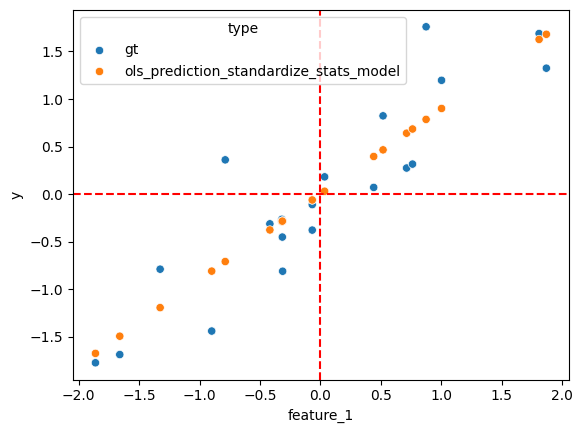

In [149]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=concat_standardize_stats_model_df, x="feature_1", y="y", hue="type", ax=axes)
axes.axhline(0, color='r', linestyle="--")
axes.axvline(0, color='r', linestyle="--")

## Way 3: Standardize ONLY input variables, not output variable BUT ALSO ADD BIAS

In [153]:
# X_standardize = StandardScaler().fit_transform(X)
# y_standardize = StandardScaler().fit_transform(y.reshape(y.shape[0], 1))
X_standardize_with_bias = np.hstack((StandardScaler().fit_transform(X), np.ones((X.shape[0], 1))))
way3_standardize_gt_df = pd.DataFrame({"feature_1": X_standardize_with_bias[:, 0].reshape(-1,), "y": y.reshape(-1,), "type": "gt"})
print(f"Shape of X_standardize_with_bias: {X_standardize_with_bias.shape}")

Shape of X_standardize_with_bias: (20, 2)


In [156]:
standardize_with_bias_beta_ols = np.dot(inv(np.dot (X_standardize_with_bias.transpose(), X_standardize_with_bias)), np.dot(X_standardize_with_bias.transpose(),y.reshape(y.shape[0], 1)))

In [157]:
standardize_with_bias_beta_ols

array([[42.77405318],
       [96.9552372 ]])

In [158]:
prediction_ols_standardize_with_bias = np.dot(X_standardize_with_bias, standardize_with_bias_beta_ols)
print(f"Shape of prediction_ols_standardize_with_bias: {prediction_ols_standardize_with_bias.shape}")

Shape of prediction_ols_standardize_with_bias: (20, 1)


In [159]:
ols_prediction_standardize_with_bias_df = pd.DataFrame({"feature_1": X_standardize_with_bias[:, 0].reshape(-1,), "y": prediction_ols_standardize_with_bias.reshape(-1,), "type": "ols_prediction_standardize_with_bias"})

In [163]:
concat_ols_prediction_standardize_with_bias_df = pd.concat([way3_standardize_gt_df, ols_prediction_standardize_with_bias_df], axis=0)

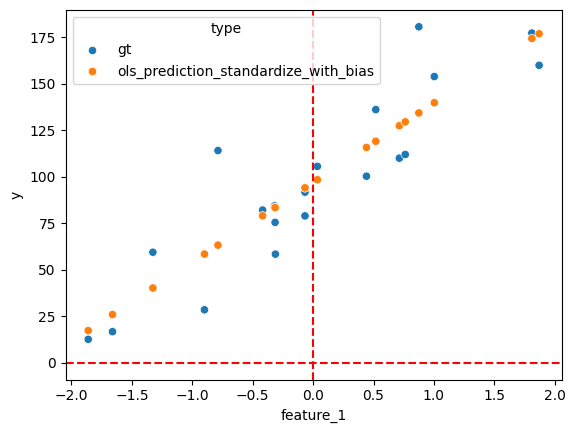

In [165]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=concat_ols_prediction_standardize_with_bias_df, x="feature_1", y="y", hue="type", ax=axes)
axes.axhline(0, color='r', linestyle="--")
axes.axvline(0, color='r', linestyle="--")

## Best option is to standardize input and output variables WITHOUT bias

## Check whether OLS estimates are scale invariant?
=> If the input features are all at different scales, does it impact the coefficients?

## https://www.statlect.com/fundamentals-of-statistics/ridge-regression

In [252]:
def scale_feature_and_perform_ols(X, y, scale_factor_list=[0.001, 0.1, 1, 5, 100, 535]):
  result_df = pd.DataFrame({"feature": X.reshape(-1,), "y":y, "type": "gt"})
  for scale_factor in scale_factor_list:
    #print(f"scale_factor: {scale_factor}")
    ## Step 1: Randomly choose a feature
    random_feature_to_scale_index= random.choice(range(X.shape[1]))

    ## Step 2: Scale the chosen feature
    new_X = X.copy()
    new_X = X[:, random_feature_to_scale_index].reshape(-1, 1) * scale_factor
    new_X = np.hstack((new_X, np.ones((new_X.shape[0], 1))))
    #print(f"Shape of new_X: {new_X.shape}")

    ## Step 3: Perform OLS (This gives coefficients that are inverse scaled compared to NON SCALED X OLS REGRESSION)
    beta_ols = np.dot(inv(np.dot (new_X.transpose(), new_X)), np.dot(new_X.transpose(),y.reshape(y.shape[0], 1)))

    ## print(beta_ols)
    #print(f"Shape of beta_ols: {beta_ols.shape}")

    ## Step 4: Perform prediction (Exactly same as NON SCALED OLS REGRESSION)
    prediction_ols = np.dot(new_X, beta_ols)
    #print(f"Shape of prediction_ols: {prediction_ols.shape}")

    ## Step 5: Create dataframe
    current_prediction_df = pd.DataFrame({"feature": X[:, 0].reshape(-1,), "y": prediction_ols.reshape(-1,), "type": f"ols_regression{scale_factor}"})
    #print(f"Shape of current_prediction_df: {current_prediction_df.shape}")

    result_df = pd.concat([result_df, current_prediction_df], axis=0)

  return result_df

In [253]:
scale_feature_perform_ols_df = scale_feature_and_perform_ols(X, y, scale_factor_list=[0.001, 0.1, 5, 100, 535])

<Axes: xlabel='feature', ylabel='y'>

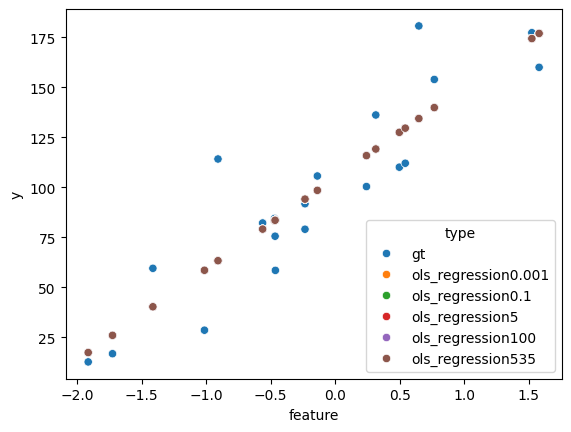

In [254]:
sns.scatterplot(data=scale_feature_perform_ols_df, x="feature", y="y", hue="type").set_title("OLS regression prediction is scale invariant")

## This clearly shows that OLS regression yields same predictions no matter how scaled the input variables are!!!!
## Ridge regression does not possess this quality

## This shows that when regressors/ inputs are multipled/ scaled by a factor, the corrsponding coefficients are also inverse scaled
## OLS coefficients are scale invariant.

NOte:
1. It is very important to ass a constant column to design matrix. Otherwise the line/ plane is forced to pass through origin
2. OR centrize the features and output before fitting the line

## Shoe that OLS has high variance and hence OVERFITS

In [377]:
## https://stackoverflow.com/questions/51972637/nonlinear-regression-with-python-whats-a-simple-method-to-fit-this-data-bette
xData = np.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
yData = np.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])

In [378]:
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.20, shuffle=True)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (32,)
Shape of X_test: (9,)


In [379]:
train_df = pd.DataFrame({"x": X_train.reshape(-1,), "y":y_train, "type": "train"})
test_df = pd.DataFrame({"x": X_test.reshape(-1,), "y":y_test, "type": "test"})

In [380]:
split_df = pd.concat([train_df, test_df], axis=0)

<Axes: xlabel='x', ylabel='y'>

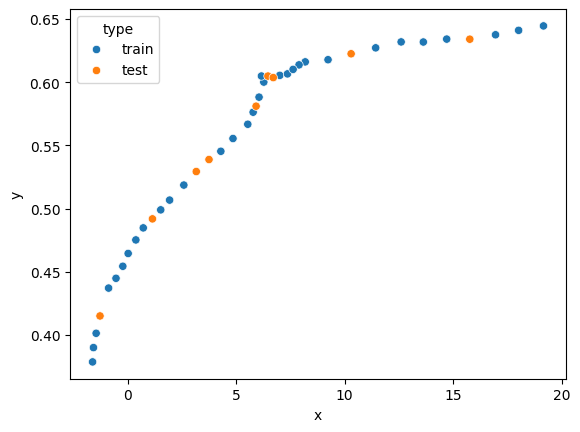

In [381]:
sns.scatterplot(data=split_df, x="x", y="y", hue="type")

In [382]:
split_model = ols('y ~ x', data=train_df).fit()

In [383]:
split_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     116.5
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           7.51e-12
Time:                        05:39:25   Log-Likelihood:                 60.023
No. Observations:                  32   AIC:                            -116.0
Df Residuals:                      30   BIC:                            -113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4755      0.010     49.058      0.000       0.456       0.495
x              0.0124      0.001     10.793      0.000       0.010       0.015
==============================================================================
Omnibus:                        2.969   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.344
Skew:                          -0.527   Prob(JB):                        0.310
Kurtosis:                       2.196   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [384]:
split_model_train_prediction = split_model.predict(train_df)
split_model_test_prediction = split_model.predict(test_df)

In [385]:
split_model.params.loc["Intercept"]

0.4754771821757162

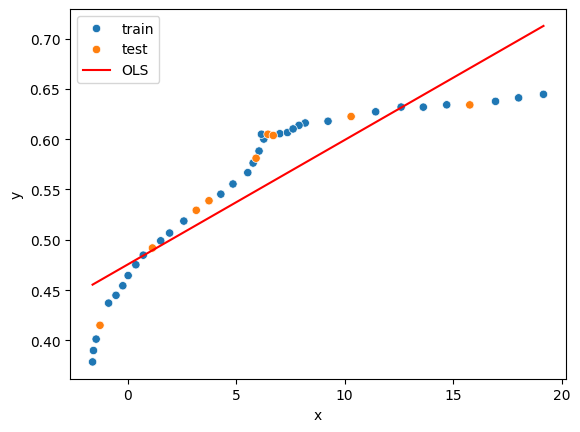

In [386]:
fig, axes = plt.subplots(1,1)
sns.scatterplot(data=split_df, x="x", y="y", hue="type", ax=axes)
x_values = np.linspace(split_df.x.min(), split_df.x.max(), 100)
y_values = split_model.params.loc["x"]*x_values + split_model.params.loc["Intercept"]
axes.plot(x_values, y_values, '-r', label="OLS")
axes.legend(loc='upper left')

In [387]:
mean_squared_error(train_df["y"], split_model_train_prediction)

0.0013750222907062577

In [388]:
mean_squared_error(test_df["y"], split_model_test_prediction)

0.0010837428298496683

In [391]:
ols_cv_results = cross_validate(LinearRegression(), X_train.reshape(-1, 1), y_train, cv=3, return_train_score=True, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))

In [392]:
print(f"Mean r2: train:{np.mean(ols_cv_results['train_r2'])}")
print(f"Mean r2: test:{np.mean(ols_cv_results['test_r2'])}")

print(f"Mean neg_mean_squared_error: train:{np.mean(ols_cv_results['train_neg_mean_squared_error'])}")
print(f"Mean neg_mean_squared_error: test:{np.mean(ols_cv_results['test_neg_mean_squared_error'])}")

print(f"Mean neg_mean_absolute_percentage_error: train:{np.mean(ols_cv_results['train_neg_mean_absolute_percentage_error'])}")
print(f"Mean neg_mean_absolute_percentage_error: test:{np.mean(ols_cv_results['test_neg_mean_absolute_percentage_error'])}")

Mean r2: train:0.8004455455350827
Mean r2: test:0.6633008114519688
Mean neg_mean_squared_error: train:-0.0012951359044663672
Mean neg_mean_squared_error: test:-0.0018886913756536354
Mean neg_mean_absolute_percentage_error: train:-0.0570130213741945
Mean neg_mean_absolute_percentage_error: test:-0.06904884984518626


This clearly shows that the model is overfitting since mean r2 for train << mean r2 for validation sets

## Plot OLS regression lines using CV. As dat points change, the line should also shift significantly, indicating high sensitivity to change in input

In [402]:
def perfom_ols_with_cv(X, y, n_folds=3):
  return_df = pd.DataFrame()
  kf = KFold(n_splits=n_folds)
  for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    # print(f"Shape of X_train: {X_train.shape}")
    # print(f"Shape of y_train: {y_train.shape}")
    # print(f"Shape of X_test: {X_test.shape}")
    # print(f"Shape of y_test: {y_test.shape}")
    # print("=====")
    train_df = pd.DataFrame({"x": X_train.reshape(-1,), "y": y_train, "type": "train"})
    test_df = pd.DataFrame({"x": X_test.reshape(-1,), "y": y_test, "type": "test"})
    split_model = ols('y ~ x', data=train_df).fit()
    #print(split_model.params)

    x_values = np.linspace(X.min(), X.max(), 100)
    predictions = split_model.params.loc["x"]*x_values + split_model.params.loc["Intercept"]
    prediction_df = pd.DataFrame({"x": x_values, "y": predictions, "type": "prediction"})

    combined_df = pd.concat([train_df, test_df, prediction_df], axis=0)
    combined_df["fold"] = f"fold{i}_slope{round(split_model.params.loc['x'], 4)}"
    #combined_df["slope"] = split_model.params.loc["x"]
    return_df = pd.concat([return_df, combined_df], axis=0)

  return return_df

In [393]:
# ## https://inria.github.io/scikit-learn-mooc/python_scripts/linear_regression_non_linear_link.html
# # rng = np.random.RandomState(0)
# # n_sample = 100
# # data_max, data_min = 1.4, -1.4
# # len_data = data_max - data_min
# # # sort the data to make plotting easier later
# # data = np.sort(rng.rand(n_sample) * len_data - len_data / 2)
# # noise = rng.randn(n_sample) * 0.3
# # target = data**3 - 0.5 * data**2 + noise
# ## https://stackoverflow.com/questions/51972637/nonlinear-regression-with-python-whats-a-simple-method-to-fit-this-data-bette
# xData = np.array([19.1647, 18.0189, 16.9550, 15.7683, 14.7044, 13.6269, 12.6040, 11.4309, 10.2987, 9.23465, 8.18440, 7.89789, 7.62498, 7.36571, 7.01106, 6.71094, 6.46548, 6.27436, 6.16543, 6.05569, 5.91904, 5.78247, 5.53661, 4.85425, 4.29468, 3.74888, 3.16206, 2.58882, 1.93371, 1.52426, 1.14211, 0.719035, 0.377708, 0.0226971, -0.223181, -0.537231, -0.878491, -1.27484, -1.45266, -1.57583, -1.61717])
# yData = np.array([0.644557, 0.641059, 0.637555, 0.634059, 0.634135, 0.631825, 0.631899, 0.627209, 0.622516, 0.617818, 0.616103, 0.613736, 0.610175, 0.606613, 0.605445, 0.603676, 0.604887, 0.600127, 0.604909, 0.588207, 0.581056, 0.576292, 0.566761, 0.555472, 0.545367, 0.538842, 0.529336, 0.518635, 0.506747, 0.499018, 0.491885, 0.484754, 0.475230, 0.464514, 0.454387, 0.444861, 0.437128, 0.415076, 0.401363, 0.390034, 0.378698])

In [403]:
cv_prediction_df = perfom_ols_with_cv(xData, yData, n_folds=3)

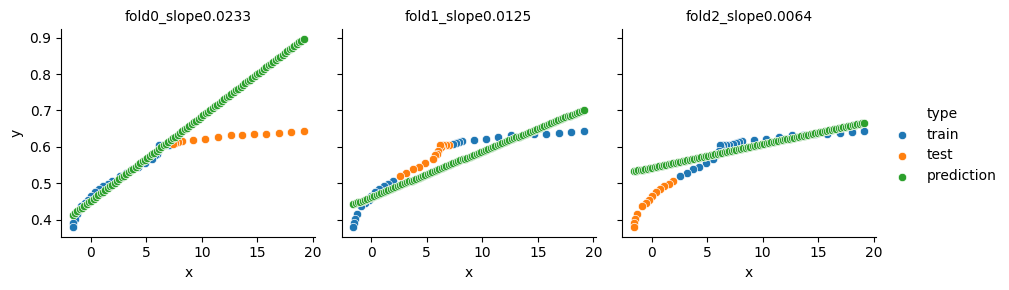

In [404]:
g = sns.FacetGrid(cv_prediction_df, col="fold", hue="type", sharex=True)
g.map(sns.scatterplot, "x", "y")
g.set_titles(col_template="{col_name}")
g.add_legend()

Clear that the slope of the learned line changes with change in data. This means that the model is very senstive to change in input => High variance => Overfitting

## Ridge regression
1. Always standardize both input and output variables. This is a requirement since Ridge coefficients are NOT SCALE INVARIANT. This means that as scale of input variable changes => the coefficient changes (not in proportion to scale). Standardization ensures that all columns/ features are at same scale

2. No need to add constant since we will have to use standardized variables (input/ output)

2. Ridge coefficients achieve low variance but introducing some bias i.e. forcing model paramaters to have smaller values

3. Ridge regrression is very useful when OLS fails i.e. multicollinearity / large number of predictors etc.
4. Helps in model regularization by forcing model to have lower slope => less sensitivity to change in input
5. by the Gauss-Markov theorem, the OLS estimator has the lowest variance (and the lowest MSE) among the estimators that are unbiased, there exists a biased estimator (a ridge estimator) whose MSE is lower than that of OLS.

https://www.statlect.com/fundamentals-of-statistics/ridge-regression